In [209]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import statsmodels.api as sm
import scipy.stats as stats

In [210]:
sns.set_theme()

In [211]:
IMAGES_PATH = Path("../images/")
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Prepare the data

In [212]:
ticker = 'msft'

In [213]:
with pd.HDFStore('../data/data.h5') as store:
    passive_rets = store[f'models/results/{ticker}']['target_1d']

In [214]:
strats = ['vot_clf']

In [215]:
active_rets = (pd.read_hdf('../data/backtrader.h5', f'pyfolio/{ticker}/{strat}/returns'))
active_rets = active_rets.tz_convert(None)

In [216]:
active_rets.name = 'active'
passive_rets.name= 'passive'

In [217]:
market_index = pd.read_hdf('../data/assets.h5', 'yfinance/prices/test/vti')

In [226]:
#market_rets = np.log(market_index['Adj Close']/market_index['Adj Close'].shift(1)).dropna()
#market_rets = market_rets.loc[passive_rets.index]
#market_rets.name = 'market_index'

In [ ]:
returns = pd.DataFrame([market_rets, passive_rets, active_rets]).T

# Examining distribution

In [94]:
returns.describe()

,market_index,passive,active
count,1698.000000,1698.000000,1698.000000
mean,0.000424,0.000932,0.001364
std,0.012338,0.017729,0.033405
min,-0.120822,-0.159453,-0.147361
25%,-0.003879,-0.006331,-0.003303
50%,0.000721,0.000961,0.000000
75%,0.006031,0.009962,0.011344
max,0.090661,0.132929,0.145804


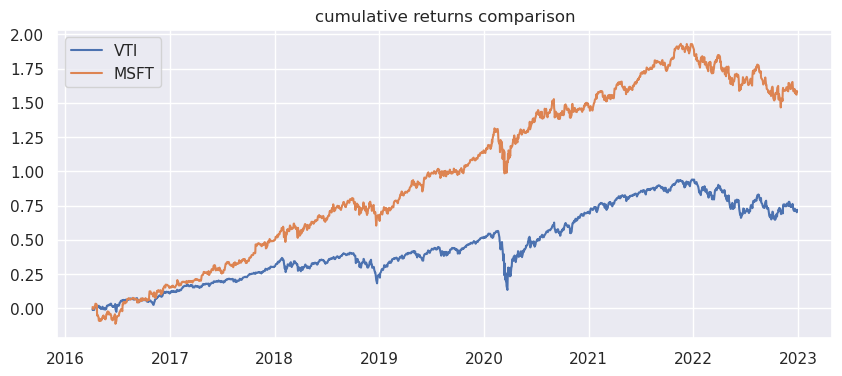

In [225]:
fig,ax = plt.subplots(figsize=(10,4))

plt.plot(returns.market_index.cumsum(), label='VTI')
plt.plot(returns.passive.cumsum(), label = 'MSFT')
plt.title('cumulative returns comparison')
plt.legend()
plt.show()

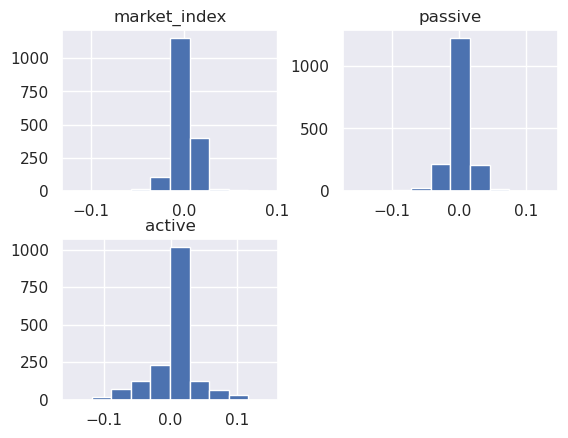

In [208]:
returns.hist()
plt.show()

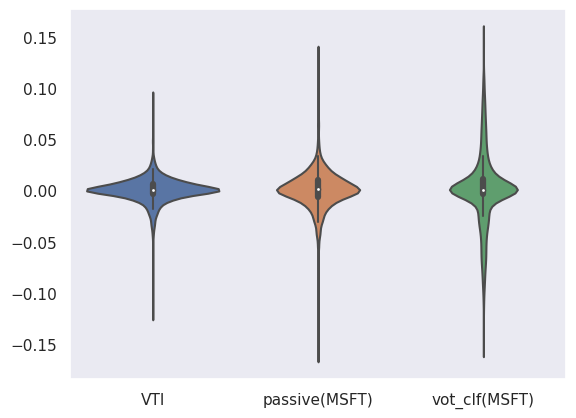

In [205]:
d = sns.violinplot(returns.rename(columns={'market_index': 'VTI',
                                  'passive': 'passive(MSFT)',
                                  'active': 'vot_clf(MSFT)'}))
d.grid(False)
#save_fig("distribution_returns_MSFT")

In [102]:
market_alpha = market_rets.sum() - active_rets.sum()

In [103]:
passive_alpha = passive_rets.sum() - active_rets.sum()

# Test 1: passive vs active

In [104]:
excess_returns = passive_rets - active_rets

In [110]:
from sklearn.utils import resample

In [190]:
def boostrap(x, b=10000, alpha = 0.05, plot=False):
    n = len(x)
    mu = x.mean()
    se_mean = x.std()/np.sqrt(n)
    qt = stats.t.ppf(q= 1-alpha, df=n-1)
    
    #generate bootstrap distribution of sample mean
    mean_samples = []
    for i in range(0,b):
        mean_samples.append(resample(x, replace=True, n_samples=30).mean())
        
    mean_samples = np.array(mean_samples)
    #standard error and sample quantiles
    se_mean_boot = mean_samples.mean()
    quantile_boot = np.percentile(mean_samples,95)
    
    #Results
    print("Estimated mean:", mu)
    print("Classic standard error:", se_mean)
    print("Classic student c.i.:", mu + np.array([-qt, qt])*se_mean)
    print("\nBootstrap results:")
    print("Standard error:", se_mean_boot)
    print("t-type CI:",mu + np.array([qt, -qt])*se_mean_boot)
    print("Percentile CI:", quantile_boot)
    
    if plot:
        g=sns.displot(mean_samples, kde=True)
        g.figure.set_size_inches(10, 4)
        plt.axvline(x=np.percentile(mean_diff, 95), color ='r')


Estimated mean: -0.000940089951427742
Classic standard error: 0.0007781181988183305
Classic student c.i.: [-0.00222068  0.0003405 ]

Bootstrap results:
Standard error: -0.0009351997343316006
t-type CI: [-0.0024792   0.00059902]
Percentile CI: 0.008581969056275226


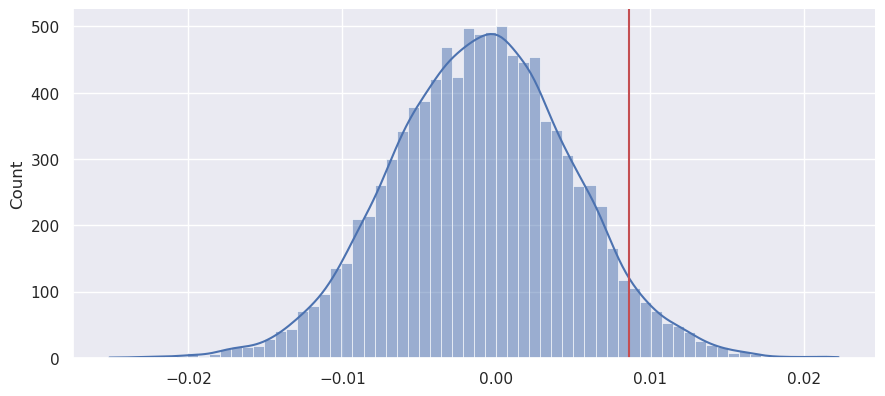

In [191]:
boostrap(np.array(excess_returns), plot = True)

In [170]:
def draw_qqplot(x):
    
    n = 10000
    z = (x - np.mean(x))/np.std(x)
    
    stats.probplot(z, dist="norm", plot=plt)
    plt.show()

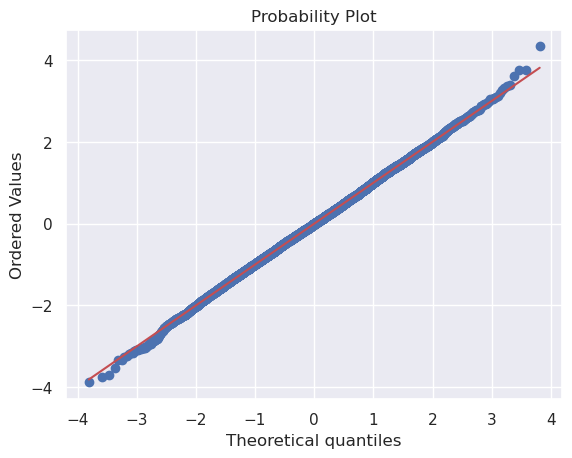

In [171]:
draw_qqplot(mean_diff)